In [1]:
from sklearn.cluster import KMeans
import torch
from torch.nn import Embedding
from torch.utils.data import DataLoader
import torch.nn as nn
EPS = 1e-15
from torch.nn import Parameter
import pandas as pd
import numpy as np
device = 'cpu'
from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from torch_geometric.datasets import Planetoid
import copy
import matplotlib.pyplot as plt
import pandas as pd
from torch_geometric.datasets import KarateClub

C:\Users\ZHANGSHANFAN\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_graph(nodes_number):
    # use all edges to train
    dataset = KarateClub()
    data = dataset[0]
    edges = data.edge_index
    start_nodes = np.array(edges[0])
    end_nodes = np.array(edges[1])
    
    graph_np = np.zeros((nodes_number, nodes_number))

    for i in range(edges.shape[1]):
        graph_np[start_nodes[i], end_nodes[i]]=1
    
    for i in range(nodes_number):
        graph_np[i,i]=1
    
    nega_edge = np.argwhere(graph_np == 0) 
    posi_edge = np.argwhere(graph_np == 1)
    posi_edge_number = posi_edge.shape[0]
    
    choose_positive = posi_edge
    choose_negative = nega_edge
    test_posi = [list(choose_positive[i]) for i in range(len(choose_positive))]
    test_nega = [list(choose_negative[i]) for i in range(len(choose_negative))]
    test_index = test_posi + test_nega
    test_mask = [test_index[i][0]*nodes_number+test_index[i][1] for i in range(len(test_index))]
    test_mask = torch.tensor(test_mask)
    
    train_positive = posi_edge
    train_negative = nega_edge
    train_posi = [list(train_positive[i]) for i in range(len(train_positive))]
    train_nega = [list(train_negative[i]) for i in range(len(train_negative))]
    train_index = train_posi + train_nega
    train_mask = [train_index[i][0]*nodes_number+train_index[i][1] for i in range(len(train_index))]
    train_mask = torch.tensor(train_mask)
    
    graph_tensor = torch.from_numpy(graph_np).float()
    train_edge = torch.take(graph_tensor, train_mask)
    test_edge = np.array(torch.take(graph_tensor, test_mask))
    
    return train_edge, test_edge, train_mask, test_mask

In [3]:
def predict_auc(recons_edges, true_edges):
    predict_graph = recons_edges
    predict_edges = np.array(predict_graph)
    #print("AP SCORE： ",average_precision_score(true_edges, predict_edges))
    #print("AUC SCORE: ",roc_auc_score(true_edges, predict_edges))
    return average_precision_score(true_edges, predict_edges), roc_auc_score(true_edges, predict_edges)

In [4]:
alpha = 1.0
nodes_number = 34
train_edge, test_edge, train_mask, test_mask = get_graph(nodes_number)

In [5]:
nodes_embedding = pd.read_excel("karate_embedding.xlsx", header=None)

In [6]:
nodes_embedding = torch.from_numpy(np.array(nodes_embedding))

In [7]:
nodes_embedding.shape

torch.Size([34, 9])

In [8]:
cluster_centers = pd.read_excel("karate_centers.xlsx", header=None)

In [9]:
cluster_centers = torch.from_numpy(np.array(cluster_centers))

In [10]:
cluster_centers.shape

torch.Size([5, 9])

In [11]:
def computer_edge_prob(ne, cc):
    CC = cc
    NE = ne
    norm_squared = torch.sum((NE.unsqueeze(1) - CC)**2, 2)   
    numerator = 1.0 / (1.0 + (norm_squared / alpha))
    power = float(alpha + 1) / 2   
    numerator = numerator**power    
    soft_assignments = (numerator.t() / torch.sum(numerator, 1)).t() #soft assignment using t-distribution
    node_cluster = soft_assignments.argmax(1)    
    
    prod = torch.mm(soft_assignments, soft_assignments.t())
    norm = torch.norm(soft_assignments,p=2,dim=1).unsqueeze(0)
    clusters_similar = prod.div(torch.mm(norm.t(),norm))
    
    nodes_distance = torch.norm(NE[:, None]-NE, dim=2, p=2)
    nodes_distance = torch.div(nodes_distance, torch.max(nodes_distance))
    
    distance_similar = torch.div(beta*nodes_distance, clusters_similar)      
    nodes_similar = torch.exp(-distance_similar)
    nodes_similar = torch.div(nodes_similar, torch.max(nodes_similar))
    
    recons_test_edges = torch.take(nodes_similar, test_mask).detach()
    ap, auc = predict_auc(recons_test_edges, test_edge)
    print("ap : ",ap)
    print("auc : ",auc)
    return nodes_similar, node_cluster

In [12]:
alpha = 1.0
beta = 4.5
similar, clusters = computer_edge_prob(nodes_embedding, cluster_centers)

ap :  0.9127715151156509
auc :  0.9786858450474011


In [13]:
s = copy.deepcopy(similar)

In [14]:
dataset = KarateClub()
data = dataset[0]
edges = data.edge_index
start_nodes = np.array(edges[0])
end_nodes = np.array(edges[1])

graph_np = np.zeros((nodes_number, nodes_number))

for i in range(edges.shape[1]):
    graph_np[start_nodes[i], end_nodes[i]]=1

In [15]:
graph_np

array([[0., 1., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 1.],
       [0., 0., 1., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [16]:
true_edges = graph_np.reshape(nodes_number*nodes_number)

In [17]:
for gama in [0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9]:
    print("gama : ",gama)
    nodes_s = copy.deepcopy(s)
    for i in range(nodes_s.shape[0]):
        nodes_s[i,i]=0
    nodes_s[nodes_s>gama] = 1
    nodes_s[nodes_s<=gama] = 0
    pred_edges = nodes_s.reshape(nodes_number*nodes_number)
    print("edges： ",pred_edges.sum())
    print("ACC SCORE： ",accuracy_score(true_edges, pred_edges))

gama :  0.2
edges：  tensor(210., dtype=torch.float64)
ACC SCORE：  0.9290657439446367
gama :  0.25
edges：  tensor(164., dtype=torch.float64)
ACC SCORE：  0.9550173010380623
gama :  0.3
edges：  tensor(128., dtype=torch.float64)
ACC SCORE：  0.9273356401384083
gama :  0.35
edges：  tensor(114., dtype=torch.float64)
ACC SCORE：  0.9256055363321799
gama :  0.4
edges：  tensor(106., dtype=torch.float64)
ACC SCORE：  0.9256055363321799
gama :  0.45
edges：  tensor(98., dtype=torch.float64)
ACC SCORE：  0.9325259515570934
gama :  0.5
edges：  tensor(94., dtype=torch.float64)
ACC SCORE：  0.9290657439446367
gama :  0.55
edges：  tensor(76., dtype=torch.float64)
ACC SCORE：  0.9238754325259516
gama :  0.6
edges：  tensor(64., dtype=torch.float64)
ACC SCORE：  0.916955017301038
gama :  0.65
edges：  tensor(56., dtype=torch.float64)
ACC SCORE：  0.9100346020761245
gama :  0.7
edges：  tensor(38., dtype=torch.float64)
ACC SCORE：  0.8944636678200693
gama :  0.75
edges：  tensor(26., dtype=torch.float64)
ACC SCORE：  0

In [18]:
gama = 0.25
for i in range(s.shape[0]):
    s[i,i]=0
s[s>gama] = 1
s[s<=gama] = 0
predict_edges = s.reshape(nodes_number*nodes_number)
print("ACC： ",accuracy_score(true_edges, predict_edges))
print("AP： ",precision_score(true_edges, predict_edges, average='macro'))
print("RECALL： ",recall_score(true_edges, predict_edges, average='macro'))
print("F1 SCORE： ",f1_score(true_edges, predict_edges, average='macro'))

ACC：  0.9550173010380623
AP：  0.8974478756884343
RECALL：  0.9144871794871794
F1 SCORE：  0.9056977911646585


In [19]:
s.sum()

tensor(164., dtype=torch.float64)

In [20]:
nodes_similar = np.array(s)
clusters = np.array(clusters)

In [21]:
nodes_similar, clusters

(array([[0., 1., 1., ..., 0., 0., 0.],
        [1., 0., 1., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 1., 1.],
        ...,
        [0., 0., 0., ..., 0., 1., 1.],
        [0., 0., 1., ..., 1., 0., 1.],
        [0., 0., 1., ..., 1., 1., 0.]]),
 array([2, 2, 2, 2, 1, 1, 1, 2, 4, 2, 1, 1, 2, 2, 3, 3, 1, 2, 3, 4, 3, 2,
        3, 0, 0, 0, 3, 0, 0, 3, 4, 0, 4, 3], dtype=int64))

In [22]:
from sklearn.decomposition import PCA

In [23]:
def get_coordinate(nes, ccs):
    NS = nodes_similar
    NC = clusters

    c_ini = np.array(cluster_centers)
    pca = PCA(n_components=2)   
    c_ini = pca.fit_transform(c_ini) 
    c_ini_x=c_ini[:,0]
    c_ini_y=c_ini[:,1]

    ne_ini = np.array(nodes_embedding)
    pca = PCA(n_components=2)   
    ne_ini = pca.fit_transform(ne_ini) 
    ne_ini_x = ne_ini[:,0]
    ne_ini_y = ne_ini[:,1]

    cluster_0_index = np.argwhere(NC==0)
    cluster_0_index = cluster_0_index.reshape(cluster_0_index.shape[0])
    cluster_0_nodes = ne_ini[cluster_0_index]
    cluster_0_x = cluster_0_nodes[:,0]
    cluster_0_y = cluster_0_nodes[:,1]

    cluster_1_index = np.argwhere(NC==1)
    cluster_1_index = cluster_1_index.reshape(cluster_1_index.shape[0])
    cluster_1_nodes = ne_ini[cluster_1_index]
    cluster_1_x = cluster_1_nodes[:,0]
    cluster_1_y = cluster_1_nodes[:,1]

    cluster_2_index = np.argwhere(NC==2)
    cluster_2_index = cluster_2_index.reshape(cluster_2_index.shape[0])
    cluster_2_nodes = ne_ini[cluster_2_index]
    cluster_2_x = cluster_2_nodes[:,0]
    cluster_2_y = cluster_2_nodes[:,1]
    
    cluster_3_index = np.argwhere(NC==3)
    cluster_3_index = cluster_3_index.reshape(cluster_3_index.shape[0])
    cluster_3_nodes = ne_ini[cluster_3_index]
    cluster_3_x = cluster_3_nodes[:,0]
    cluster_3_y = cluster_3_nodes[:,1]
    
    cluster_4_index = np.argwhere(NC==4)
    cluster_4_index = cluster_4_index.reshape(cluster_4_index.shape[0])
    cluster_4_nodes = ne_ini[cluster_4_index]
    cluster_4_x = cluster_4_nodes[:,0]
    cluster_4_y = cluster_4_nodes[:,1]
    
    return cluster_0_x, cluster_0_y, cluster_1_x, cluster_1_y, cluster_2_x, cluster_2_y, cluster_3_x, cluster_3_y, cluster_4_x, cluster_4_y, c_ini_x, c_ini_y, NS, ne_ini_x, ne_ini_y

In [24]:
import networkx as nx
NS, NC = nodes_similar, clusters
print("edges： ",NS.sum())
G_predict=nx.from_numpy_array(NS)
node_cluster=list(NC)
node_dict={node:str(cluster) for node,cluster in enumerate(node_cluster)}
nx.set_node_attributes(G_predict,node_dict,'cluster')

dataset = KarateClub()
data = dataset[0]
edges = data.edge_index
start_nodes = np.array(edges[0])
end_nodes = np.array(edges[1])
graph_np = np.zeros((nodes_number, nodes_number))
for i in range(edges.shape[1]):
    graph_np[start_nodes[i], end_nodes[i]]=1
G_true=nx.from_numpy_array(graph_np)

edges：  164.0


In [25]:
clusters

array([2, 2, 2, 2, 1, 1, 1, 2, 4, 2, 1, 1, 2, 2, 3, 3, 1, 2, 3, 4, 3, 2,
       3, 0, 0, 0, 3, 0, 0, 3, 4, 0, 4, 3], dtype=int64)

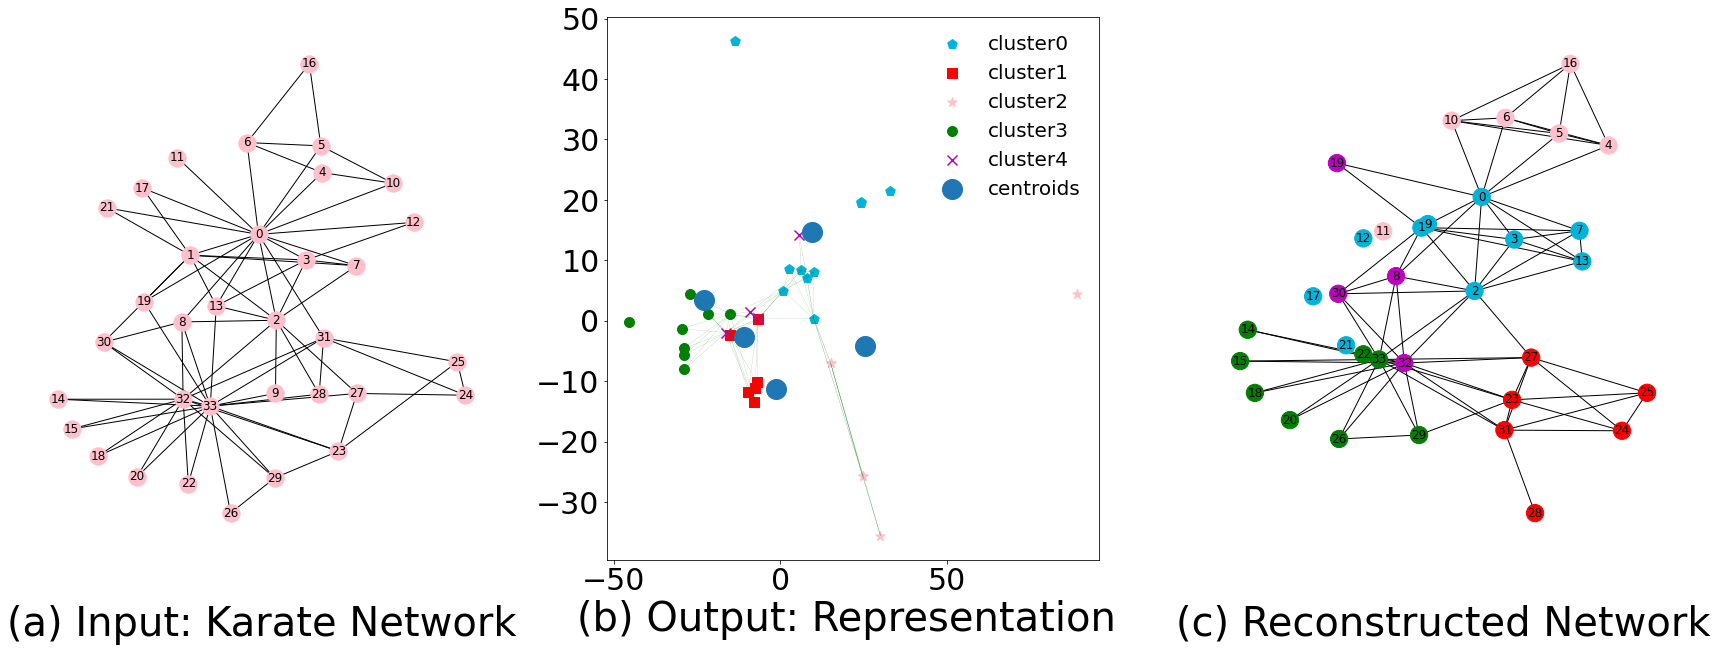

In [57]:
plt.figure(figsize=(30, 10))
grid=plt.GridSpec(1,3)

AX2 = plt.subplot(grid[0, 0])
true_pos=nx.kamada_kawai_layout(G_true)
nx.draw(G_true,true_pos,with_labels = True,node_color = 'pink',node_size = 300, width=1, ax=AX2)
plt.title("(a) Input: Karate Network",fontsize=40,y=-0.15)

AX1 = plt.subplot(grid[0, 1])
cluster_0_x, cluster_0_y, cluster_1_x, cluster_1_y, cluster_2_x, cluster_2_y, cluster_3_x, cluster_3_y, cluster_4_x, cluster_4_y, c_ini_x, c_ini_y, NS, ne_ini_x, ne_ini_y = get_coordinate(all_nodes_embedding, all_cluster_centers) 
AX1.scatter(cluster_0_x, cluster_0_y, s=100, marker='p', c='#00b4d9', label='cluster0')
AX1.scatter(cluster_1_x, cluster_1_y, s=100, marker='s', c='r', label='cluster1')
AX1.scatter(cluster_2_x, cluster_2_y, s=100, marker='*', c='pink', label='cluster2')
AX1.scatter(cluster_3_x, cluster_3_y, s=100, marker='o', c='g', label='cluster3')
AX1.scatter(cluster_4_x, cluster_4_y, s=100, marker='x', c='m', label='cluster4')
AX1.scatter(c_ini_x,c_ini_y,s=400, label='centroids')
for i in range(nodes_number-1):
    for j in range(i+1,nodes_number):
        if NS[i,j]==1:
            AX1.plot([ne_ini_x[i],ne_ini_x[j]], [ne_ini_y[i],ne_ini_y[j]], color='g', linewidth=0.1)
AX1.set_xlabel('(b) Output: Representation ',fontsize=40)
AX1.tick_params(labelsize=30)
AX1.legend(loc='best',prop={'size':20},frameon=False)

AX0 = plt.subplot(grid[0, 2])
pre_pos=nx.kamada_kawai_layout(G_predict)
node_colors = []
for i in range(nodes_number):
    if clusters[i]==0:
        node_colors.append('#00b4d9')
    elif clusters[i]==1:
        node_colors.append('r')
    elif clusters[i]==2:
        node_colors.append('pink')
    elif clusters[i]==3:
        node_colors.append('g')
    elif clusters[i]==4:
        node_colors.append('m')
nx.draw(G_predict, pre_pos, with_labels=True, node_color=node_colors, node_size = 300, width=1, ax=AX0)
plt.title("(c) Reconstructed Network",fontsize=40,y=-0.15)

#plt.savefig("karate.pdf",bbox_inches='tight')
plt.show()

In [26]:
vgae_graph = pd.read_csv("karate_graph.txt", header=None).iloc[:,1:]
vgae_graph = np.array(vgae_graph)
vgae_predict=nx.from_numpy_array(vgae_graph)

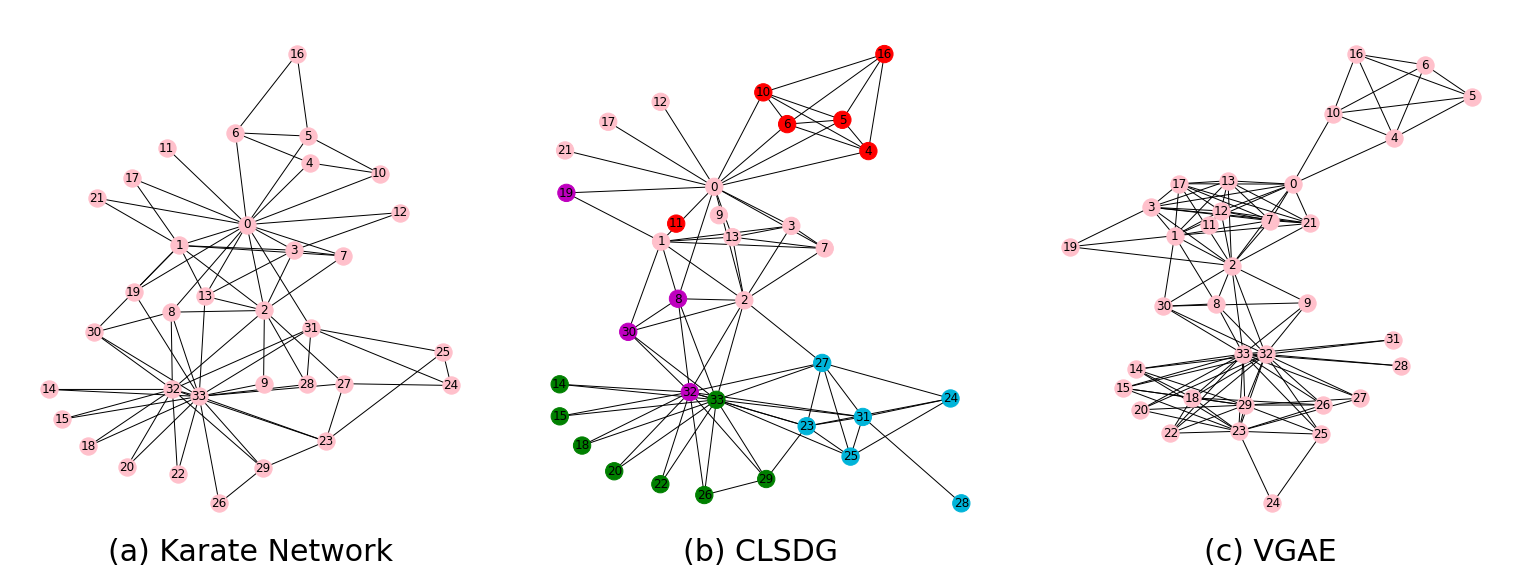

In [27]:
plt.figure(figsize=(27, 10))
plt.subplots_adjust(wspace=0.05)

grid=plt.GridSpec(1,3)

AX0 = plt.subplot(grid[0, 0])
true_pos=nx.kamada_kawai_layout(G_true)
nx.draw(G_true,true_pos,with_labels = True,node_color = 'pink',node_size = 300, width=1, ax=AX0)
plt.title("(a) Karate Network",fontsize=30,y=-0.03)

#cluster_0_x, cluster_0_y, cluster_1_x, cluster_1_y, cluster_2_x, cluster_2_y, cluster_3_x, cluster_3_y, cluster_4_x, cluster_4_y, c_ini_x, c_ini_y, NS, ne_ini_x, ne_ini_y = get_coordinate(nodes_embedding, cluster_centers) 
AX1 = plt.subplot(grid[0, 1])
pre_pos=nx.kamada_kawai_layout(G_predict)
node_colors = []
for i in range(nodes_number):
    if clusters[i]==0:
        node_colors.append('#00b4d9')
    elif clusters[i]==1:
        node_colors.append('r')
    elif clusters[i]==2:
        node_colors.append('pink')
    elif clusters[i]==3:
        node_colors.append('g')
    elif clusters[i]==4:
        node_colors.append('m')
nx.draw(G_predict, pre_pos, with_labels=True, node_color=node_colors, node_size = 300, width=1, ax=AX1)
plt.title("(b) CLSDG",fontsize=30,y=-0.03)


AX0 = plt.subplot(grid[0, 2])
vgae_pos=nx.kamada_kawai_layout(vgae_predict)
nx.draw(vgae_predict,vgae_pos,with_labels = True,node_color = 'pink',node_size = 300, width=1, ax=AX0)
#true_pos=nx.kamada_kawai_layout(vgae_predict)
#nx.draw(vgae_predict,vgae_pos,with_labels = True,node_color = 'pink',node_size = 300, width=1, ax=AX0)
plt.title("(c) VGAE",fontsize=30,y=-0.03)

plt.savefig("recon_karate.pdf",bbox_inches='tight')
plt.show()

In [557]:
pd.DataFrame(np.array(all_nodes_embedding[-1])).to_excel("karate_embedding.xlsx",header=None,index=None)

In [559]:
pd.DataFrame(np.array(all_cluster_centers[-1])).to_excel("karate_centers.xlsx",header=None,index=None)

In [50]:
vgae_graph = pd.read_csv("karate_graph.txt", header=None).iloc[:,1:]
vgae_graph = np.array(vgae_graph)
vgae_predict=nx.from_numpy_array(vgae_graph)

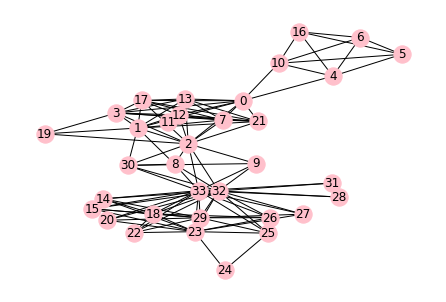

In [54]:
vgae_predict=nx.from_numpy_array(vgae_graph)
true_pos=nx.kamada_kawai_layout(vgae_predict)
nx.draw(vgae_predict,true_pos,with_labels = True,node_color = 'pink',node_size = 300, width=1)